## 8. 분류 실습 - 캐글 신용카드 사기 검출

http://www.kaggle.com/mlg-ulb/creditcardfraud  
`creditcard.csv` 파일로 실습을 진행함을 밝힘  
  
Class  속성
* 0 : 사기 X
* 1 : 사기 O   

매우 불균형한 분포를 가진다

### 언더 샘플링과 오버 샘플링의 이해

레이블이 불균형한 분포를 가진 데이터 세트를 학습시킬 때 예측 성능의 문제가 발생할 수 있는데, 이는 이상 레이블을 가지는 데이터 건수가 정상 레이블을 가진 데이터 건수에 비해 너무 적기 때문에 발생  
  
지도학습에서 불균형한 레이블 값 분포로 인한 문제점을 해결하기 위해서는 적절한 학습 데이터를 확보하는 방안이 필요  
-> 대표적으로 **오버 샘플링(Oversampling**과 **언더 샘플링(Undersampling)** 방법이 있다  
-> **`오버 샘플링`** 방식이 예측 성능상 더 유리한 경우가 많아 주로 사용  
  
* **언더 샘플링** : 많은 데이터 세트를 적은 데이터 세트 수준으로 감소시키는 방식. 정상 레이블 데이터를 이상 레이블 데이터 수준으로 줄여 버린 상태에서 학습을 수행하면 과도하게 정상 레이블로 학습/예측하는 부작용을 개선할 수 있지만, 너무 많은 정상 레이블 데이터를 감소시키기 때문에 오히려 제대로 된 학습을 수행할 수 없다는 단점이 있어 잘 적용하지 않음  
  
* **오버 샘플링** : 이상 데이터와 같이 적은 데이터 세트를 증식하여 학습을 위한 충분한 데이터를 확보하는 방법. 동일한 데이터를 단순히 증식하는 방법은 과적합이 되기 때문에 원본 데이터의 피처 값들을 약간만 변경하여 증식. 대표적으로 `SMOTE`방법이 있다.  `SMOTE`는 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃을 찾아서 이 데이터와 K개 이웃들의 차이를 일정 값으로 만들어서 기존 데이터와 약간 차이가 나는 새로운 데이터들을 생성하는 방식

### 데이터 일차 가공 및 모델 학습/예측/평가

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('data_set/creditcard.csv')
card_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
print('사기 트랜잭션 (1)의 비율 :', card_df[card_df.Class == 1].Class.count() / card_df.Class.count())

# 매우 불균형함을 보임

사기 트랜잭션 (1)의 비율 : 0.001727485630620034


In [5]:
from sklearn.model_selection import train_test_split

# 인자로 입력받는 DataFrame을 복사한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환 함수 생성
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    df_copy.drop('Time', axis = 1, inplace = True)
    return df_copy

In [6]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수
def get_train_test_dataset(df = None):
    
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    
    # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피쳐
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:,-1]
    
    # train_test_split()으로 학습/테스트 데이터 분할
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.3,
                                                       random_state = 0, stratify = y_target)
    
    # 학습/테스트 데이터 셋 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [7]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


최종적으로 나눠진 학습/테스트 데이터 셋 비율이 기존 데이터에서 가진 사기 트랜잭션의 비율과 비슷하게 분리되었음

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [13]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8835, 재현율: 0.6149,    F1: 0.7251, AUC:0.9586


테스트 데이터 세트로 측정 시 재현율이 0.6149, ROC-AUC가 0.9586이다

In [14]:
# 인자로 사이킷런의 Estimator객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train = None, tgt_test = None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [16]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


LGBM 모델로 수행 시 재현율 0.7568, ROC-AUC가 0.9790으로 앞선 로지스틱 회귀보다는 높은 수치를 보임

### 데이터 분포도 변환 후 모델 학습/예측/평가

`creditcard.csv`의 중요 피처는 **Amount**  
신용 카드 사용 금액으로 정상/사기 트랙잭션을 결정하는데 매우 중요하기 때문

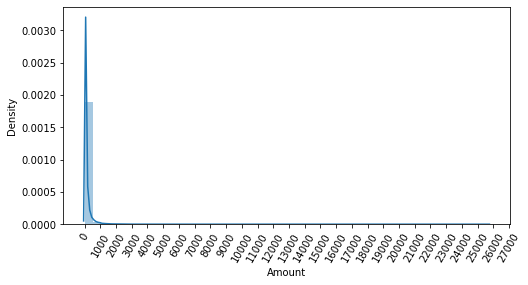

In [26]:
# Amount 피처의 분포도 확인
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.distplot(card_df['Amount'])
plt.show()

카드 사용 금액이 1000불 이하인 데이터가 압도적이다.  
Amount를 표준 정규 분포 평태로 변환한 뒤에 로지스틱 회귀의 예측 성능을 측정해보자

* StandardScaler

In [29]:
from sklearn.preprocessing import StandardScaler

def get_preprocessing_df(df = None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    
    # 변형된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    
    # 기존 Time, Amount 피처 삭제
    df_copy.drop(['Time, Amount'], axis = 1, inplace = True)
    return df_copy

In [35]:
# Amount를 정규분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('## 로지스틱 회귀 예측 성능 ##')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train = X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)

print('\n ## LightGBM 예측 성능 ##')
lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves = 64, n_jobs = -1, boost_from_average = False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

## 로지스틱 회귀 예측 성능 ##
오차 행렬
[[85283    12]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8835, 재현율: 0.6149,    F1: 0.7251, AUC:0.9586

 ## LightGBM 예측 성능 ##
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


* Log변환  
원래 로그 변환은 데이터 분포도가 심하게 왜곡되어 있을 경우 적용하는 중요 기법 중 하나  
데이터 분포도의 왜곡을 상당 수준 개선해줌

In [41]:
def get_preprocessed_df(df = None):
    df_copy = df.copy()
    
    # 넘파이의 log1p()를 이용하여 Amount 로그 변환
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis = 1, inplace = True)
    return df_copy

In [42]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('\n### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727

### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


두 모델 모두 StandardScaler보다 약간씩 성능이 개선되었음을 나타냄

### 이상치 데이터 제거 후 모델 학습/예측/평가

이상치 데이터(Outlier)는 전체 데이터의 태펀에서 벗어난 이상 값을 가진 데이터, 아웃라이어라도고 불린다.  
  
이상치를 찾는 많은 방법 중, `IQR(Inter Quantile Range)` 방식을 적용하여 이상치를 찾아보자  
  
사분위는 전체 데이터를 값의 오름차순으로 정렬하고, 이를 1/4(25%)씩으로 구간을 분할하는 것이다. 그리고 각 구간을 Q1, Q2, Q3, Q4라고 지칭한다.  
이들 중 25%구간인 Q1 ~ 75%구간인 Q3의 범위를 **IQR**이라고 한다.  
  
IQR을 사용하여 이상치를 구분하는 방법은 다음과 같다.  
보통 IQR에 1.5를 곱해서 생성된 범위를 이용해 최댓값과 최소값을 구분한다. 3/4분위수 Q3에 **IQR x 1.5**를 더해서 일반적인 데이터가 가질 수 있는 최댓값으로 설정하고, 1/4분위수 Q1에 **IQR x 1.5**를 빼서 최솟값으로 가정한다. 경우에 따라서 1.5가 아닌 다른 값을 곱하기도 하지만, 보통 1.5를 곱한다.  
이렇게 결정된 최솟값, 최댓값보다 작거나 큰 값을 이상치라 간주한다.  
  
이제 IQR을 사용하고 `boxplot`으로 이상치를 확인하고 제거해보자

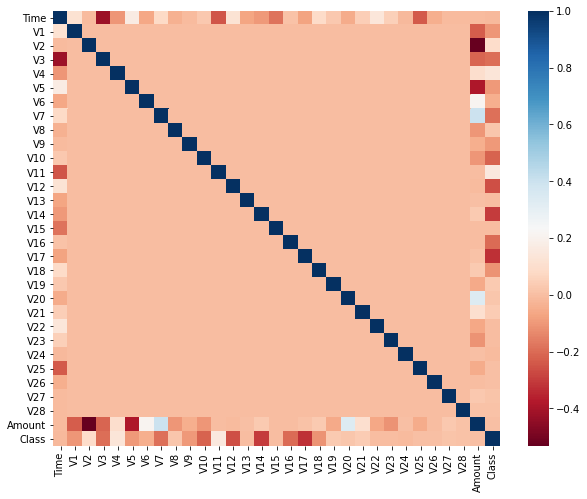

In [45]:
import seaborn as sns

plt.figure(figsize = (10,8))
corr = card_df.corr()
sns.heatmap(corr, cmap = 'RdBu') # 양의 상관관계 -> 파란색, 음의 상관관계 -> 빨간색
plt.show()

결정 레이블인 Class와 음의 상관관계가 가장 높은 피처는 V14, V17이다.  
이중 V14에서만 IQR을 사용하여 이상치를 제거해보자

In [48]:
import numpy as np

def get_outlier(df = None, column = None, weight = 1.5):
    
    #fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함
    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)
    
    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 확인
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [49]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [50]:
# get_processed_df( )를 로그 변환 후 V14 피처의 이상치 데이터를 삭제하는 로직으로 변경. 
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    # 이상치 데이터 삭제란 추가
    outlier_index = get_outlier(df = df_copy, column = 'V14', weight = 1.5)
    df_copy.drop(outlier_index, axis = 0, inplace = True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('\n### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743

### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9780


### SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가

SMOTE 적용 시 반드시 **학습 데이터 세트만 오버 샘플링을 해야 한다.**  
검증 데이터 세트나 테스트 데이터 세트를 오버 샘플링 할 경우 결국 원본 데이터 세트가 아닌 데이터 세트에서 검증/ 테스트를 수행하기 때문에 올바른 검증/테스트가 될 수 없다.

In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포: 
 0    199020
1    199020
Name: Class, dtype: int64


* LogisticRegression

In [52]:
lr_clf = LogisticRegression()

# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨에 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,    F1: 0.1023, AUC:0.9737


SMOTE로 오버 샘플링된 데이터로 학습할 경우 재현율이 92.47%로 크게 증가하지만, 반대로 정밀도가 0.05%로 급격하게 저하  
-> 재현율이 높더라도 정밀도가 낮아 현실적으로 사용되긴 힘듦  
-> 로지스틱 회귀 모델이 오버 샘플링으로 인해 실제 원본 데이터의 유형보다 너무 많은 Class=1 데이터를 학습하면서 실제 테스트 데이터 세트에서 예측을 지나치게 Class=1로 적용해 정밀도가 낮아진 것

In [53]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

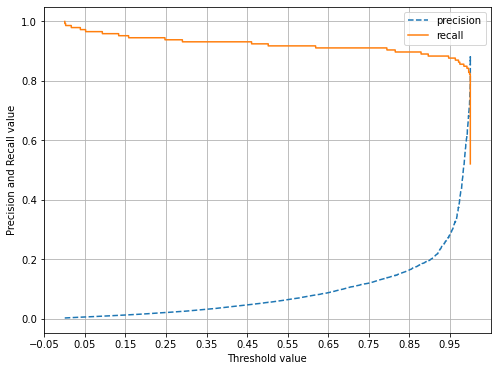

In [54]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

임계값이 0.99 이하에서는 재현율이 매우 좋고 정밀도가 극단적으로 낮다가 0.99 이상에서는 반대로 재현율이 대폭 떨어지고 정밀도가 높아진다  
  
분류 결정 임계값을 조정하더라도 임계값의 민감도가 너무 심해 올바른 재현율/정밀도 성능을 얻을 수 없으므로 로지스틱 회귀는 SMOTE 적용 후 올바른 예측 모델이 생성되지 X

* LightGBM

In [55]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[85283    12]
 [   22   124]]
정확도: 0.9996, 정밀도: 0.9118, 재현율: 0.8493,    F1: 0.8794, AUC:0.9814


SMOTE를 적용하면 재현율으 높아지나, 정밀도는 낮아지는 것이 일반적.  
좋은 SMOTE 패키지를 사용하면 재현율 증가율은 높이고, 정밀도 감소율은 낮추도록 효과적으로 데이터를 증식시킨다